<a href="https://colab.research.google.com/github/SAIIL/CVS_challenge_code/blob/main/notebooks/cvs_challenge_sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<a href="https://cvs-challenge.grand-challenge.org/">
<img src="https://rumc-gcorg-p-public.s3.amazonaws.com/b/652/CVS_Challenge_Media_-_Summit_Ad_3.x20.jpeg" align="left"/>
</a>
</div>

## <h1><center>Getting Started</center></h1>

# Introduction

In this notebook, we provide some sample code to help familiarize yourself with the challenge, the dataset and the metrics. These are minimal examples to help illustrate a simple deep learning pipeline applied on a small subset of the cvs challenge dataset.

Instructions:

*   Add a data folder next to the notebook, under `data/` with data from the Dropbox link from the challenge. Subfolders include
 * 'videos/' - contents include `video_filename.mp4`
 * 'labels/' - contents include `<video_filename>/frame.csv`,`<video_filename>/video.csv`
* Run the notebook, verify you get `results.json`. Mimic the format of `results.json` in your classification pipeline.




# Data Loading and Visualization

In [1]:
!pip install -q timm

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading code from the CVS challenge code repo
# point the mounted drive link to a copy of the key: https://drive.google.com/file/d/1xqUkSBlQ6h_kB-k2Pmo2qQMCB24xXCwx/view?usp=sharing
!mkdir /root/.ssh
!cp /content/drive/MyDrive/cvs_colab /root/.ssh/id_ed25519
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!rm -Rf CVS_challenge_code
!git clone git@github.com:SAIIL/CVS_challenge_code.git

# Add the github code folder into the python path
import sys
sys.path.insert(0,'/content/CVS_challenge_code')
# Copy data into the data dir
!mkdir ./data
!cp -r /content/drive/MyDrive/cvs_data/* ./data/

mkdir: cannot create directory ‘/root/.ssh’: File exists
# github.com:22 SSH-2.0-babeld-33961236
# github.com:22 SSH-2.0-babeld-33961236
# github.com:22 SSH-2.0-babeld-33961236
# github.com:22 SSH-2.0-babeld-33961236
# github.com:22 SSH-2.0-babeld-33961236
Cloning into 'CVS_challenge_code'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 198 (delta 90), reused 134 (delta 41), pack-reused 0
Receiving objects: 100% (198/198), 1.21 MiB | 1.60 MiB/s, done.
Resolving deltas: 100% (90/90), done.
mkdir: cannot create directory ‘./data’: File exists


In [4]:
# Import necessary libraries for this module

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import pandas as pd
import os
import glob
import json
import random
from statistics import mode

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, brier_score_loss

In [5]:
# bash to extract frames from videos. Note that "data" folder is at /content/data in the colab system

%%shell

# Change the dataset_path mentioned below appropriately if you have exracted the data to a different directory
video_folder="data/videos"
frame_folder="data/frames"
mkdir -p "$frame_folder"

video_count=0

# extract frames and save
for video_file in "$video_folder"/*.mp4; do

    base_name=$(basename "$video_file" .mp4)
    mkdir -p "$frame_folder/$base_name"

    ffmpeg -i "$video_file" -vf fps=30 -q:v 2 "$frame_folder/$base_name/%04d.jpg"

    # Break after 3rd for demonstration
    video_count=$((video_count + 1))
    if [ "$video_count" -ge 3 ]; then
        break
    fi
done

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [6]:
# visualize 18 annotated frames in a video

video_folder = 'data/videos'
frames_path = 'data/frames'
labels_path = 'data/labels'

print(os.listdir(video_folder))
video_names = [os.path.splitext(video_file)[0] for video_file in os.listdir(video_folder) if os.path.isdir(os.path.join(frames_path, os.path.splitext(video_file)[0]))]
video_name = random.choice(video_names)
print('Video:', video_name)

label_fname = os.path.join(labels_path, f"{video_name}/frame.csv")
label = pd.read_csv(label_fname)

# majority vote of 3 raters
def majority_vote(row, category):
    labels = [row[f"{category}_rater1"], row[f"{category}_rater2"], row[f"{category}_rater3"]]
    return mode(labels)

label['c1_majority'] = label.apply(majority_vote, category='c1', axis=1)
label['c2_majority'] = label.apply(majority_vote, category='c2', axis=1)
label['c3_majority'] = label.apply(majority_vote, category='c3', axis=1)
label.head(3)

['0a2bffca-9ac9-496a-8cc5-06c8a9684fbf.mp4']
Video: 0a2bffca-9ac9-496a-8cc5-06c8a9684fbf


,frame_id,c1_rater1,c1_rater2,c1_rater3,c2_rater1,c2_rater2,c2_rater3,c3_rater1,c3_rater2,c3_rater3,c1_majority,c2_majority,c3_majority
0,0,0,1,1,1,1,0,0,0,1,1,1,0
1,150,0,1,1,1,1,0,0,0,1,1,1,0
2,300,0,1,1,1,1,0,0,0,1,1,1,0


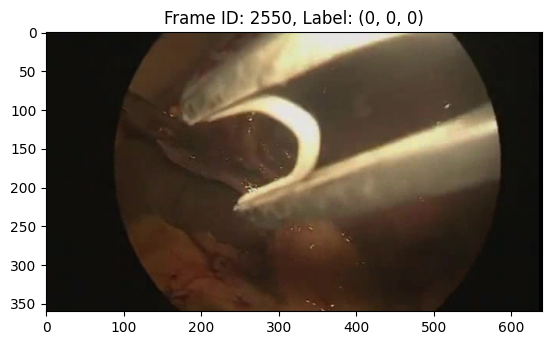

In [7]:
for index, row in label.iterrows():
    frame_id = row['frame_id']
    c1,c2,c3 = row['c1_majority'],row['c2_majority'],row['c3_majority']
    frame_path = os.path.join(frames_path, video_name, f"{frame_id+1:04d}.jpg")  # Assuming frame files are in PNG format

    img = Image.open(frame_path)
    plt.imshow(img)
    plt.title(f"Frame ID: {frame_id}, Label: {c1,c2,c3}")
    plt.show()
    plt.pause(0.1)
    clear_output(wait=True)
    plt.close()

Video 0a2bffca-9ac9-496a-8cc5-06c8a9684fbf, frame 0
Label of c1 c2 c3: tensor([1., 1., 0.])
Confidence aware labels: {'c1': 0.625, 'c2': 0.7083333333333333, 'c3': 0.2916666666666667}


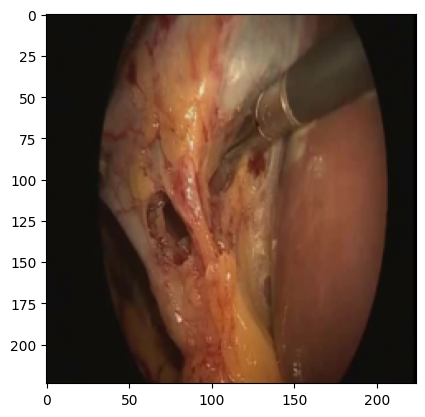

In [8]:
import datasets
import datasets.cvs_datasets
from importlib import reload
reload(datasets)
reload(datasets.cvs_datasets)
from datasets.cvs_datasets import CVSData
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

frames_path = 'data/frames'
labels_path = 'data/labels'
dataset = CVSData(frames_path=frames_path, labels_path=labels_path, transform=transform)

img, label, video_name, frame_id, metadata = dataset[0]
print(f'Video {video_name}, frame {frame_id}')
print('Label of c1 c2 c3:', label)
print(f'Confidence aware labels: {metadata["confidence_aware_labels"]}')
image_width, image_height = img.shape[2], img.shape[1]

plt.imshow(img.permute(1,2,0))
plt.show()

# Building and Running Models

We build and perform a simple forward pass of a batch input through a ViT based model to predict class label of frames

In [9]:
# Define the model for multi label classification (three labels here for c1, c2 and c3)

class ViTMultiLabelClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout=0.0, pretrained=True):
        super(ViTMultiLabelClassifier, self).__init__()
        # Pre-trained ViT as backbone
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.vit.head = nn.Identity()

        # MLP as classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes),
        )

    def forward(self, x:torch.Tensor)->torch.Tensor:
        """ Classify images
        Args:
          x (torch.Tensor): The input images, of size BxCxHxW.

        Returns:
          torch.Tensor: a Bx3 vector specifying the confidence for each label (C1,C2,C3 of the CVS)
        """
        x = self.vit(x)  # Pass input image to ViT
        x = self.classifier(x)  # Pass through MLP classifier
        return torch.sigmoid(x)  # Use sigmoid for multi-label classification

# Example of use
if __name__ == "__main__":
    model = ViTMultiLabelClassifier()
    input_tensor = torch.rand((1, 3, 224, 224))

    outputs = model(input_tensor)
    print("Model outputs:", outputs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model outputs: tensor([[0.4288, 0.5106, 0.4481]], grad_fn=<SigmoidBackward0>)


# Prediction and Evaluation

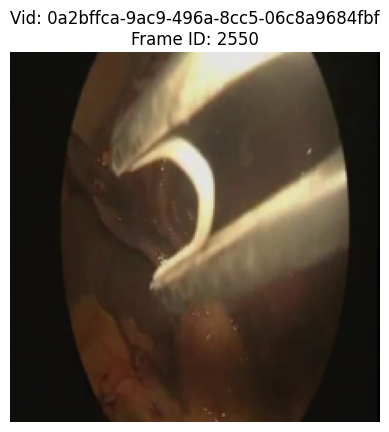

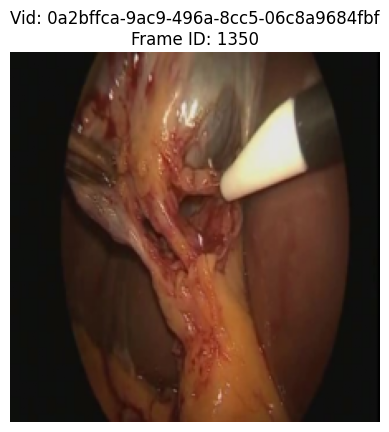

In [10]:
from util.util import save_results,load_results

# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

frames_path = 'data/frames'
labels_path = 'data/labels'

# This is an example dataset to be used within the challenge.
dataset = CVSData(frames_path=frames_path, labels_path=labels_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Create model instance
model = ViTMultiLabelClassifier()

# Estimate the label confidences over the whole dataset.
overall_outputs=[]
overall_predictions=[]
overall_labels=[]
overall_confidence_aware_labels=[]
overall_raw_labels={
                    'c1':[],
                    'c2':[],
                    'c3':[]
                    }
for img, label, video_name, frame_id, metadata in dataloader:
    output = model(img)
    prediction = (output > 0.5).float()
    overall_labels.append(label.cpu().numpy())
    overall_confidence_aware_labels.append(np.transpose(np.array([metadata['confidence_aware_labels']['c1'],
                                            metadata['confidence_aware_labels']['c2'],
                                            metadata['confidence_aware_labels']['c3']])))
    for crit in ['c1','c2','c3']:
      overall_raw_labels[crit].append(np.concatenate(np.expand_dims(metadata['raw_labels'][crit],0),1))
    overall_predictions.append(prediction.detach().cpu().numpy())
    overall_outputs.append(output.detach().cpu().numpy())

# Plot over the last example
batch_size = img.shape[0]
for i in range(batch_size):
    plt.imshow(img[i].permute(1, 2, 0))                                               # Convert from (C, H, W) to (H, W, C) for plotting
    plt.title(f"Vid: {video_name[i]}\nFrame ID: {frame_id[i]}")
    plt.axis('off')                                                                   # Hide axes
    plt.show()

for crit in ['c1','c2','c3']:
    overall_raw_labels[crit]=np.transpose(np.concatenate(overall_raw_labels[crit],1))
overall_predictions=np.concatenate(overall_predictions)                               # N_samples x 3, values are 0 or 1
overall_labels=np.concatenate(overall_labels)                                         # Ground truth values, N_samples x 3, values are 0 or 1
overall_outputs=np.concatenate(overall_outputs)                                       # N_samples x 3, values are continuous between 0 and 1
overall_confidence_aware_labels = np.concatenate(overall_confidence_aware_labels)

# Save results file. This file represents the format expected by the challenge for a given dataset.
save_results(overall_predictions,overall_outputs,'result.json')

dataset_results=load_results('result.json')

In [11]:
from util.metrics import compute_overall_metrics
'''
Evaluate metrics
aggregate for mAP, uncertainty quantification
For Subchallenge A, we are looking for models with the highest Mean Average Precision (mAP) on the full held-out 300 testing videos.

For Subchallenge B, we are looking for predictive models that is “aware” of the inherent uncertainty represented in a given image,
both in terms of the subjectivity of the task and complexity of the case being annotated.
We will calculate the uncertainty of the Brier Score (BS) over the full held-out 300 testing videos.

For Subchallenge C, we are looking for the most robust model for variations in distribution shifts.
We will use several variant testing sets which are subsampled from the 300 held-out testing videos to artificially create undisclosed distribution shifts,
based on the following factors: Use of IOC imaging, use of ICG imaging, use of a surgical robot, laparoscope type, country of origin, annotation confidence.
Performance will be calculated over all images in the dataset and then averaged across CVS criteria for each of the variant test sets.
We will pick the minimum average precisions across all these variant splits, ignoring the bottom 90th percentile to account for outliers.
'''

# Use the results from the saved json.
overall_predictions2 = dataset_results['estimated_detected_labels']
overall_outputs2 = dataset_results['estimated_label_confidences']

# Run metrics computation
print(f'Prediction of c1 c2 c3: {overall_predictions}')
print(overall_raw_labels['c1'])
print(overall_confidence_aware_labels)
print(len(overall_raw_labels['c1']))
print(len(overall_predictions2[:,i]))
metrics = compute_overall_metrics(overall_labels, overall_confidence_aware_labels, overall_outputs2)

accuracy = metrics['accuracy']
f1 = metrics['f1']
mAP = metrics['mAP']

print(f'Label of c1 c2 c3: {overall_labels}')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"mAP Score: {mAP}")

for i,key in enumerate(['c1','c2','c3']):
  brier_score = metrics['brier_score'][key]
  ece_score = metrics['ece_score'][key]
  print(f"Brier,ECE Scores for c{i}: {brier_score},{ece_score}")





Prediction of c1 c2 c3: [[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]]
[[0 0 1]
 [0 1 1]
 [1 1 1]
 [0 0 1]
 [0 1 1]
 [0 0 1]
 [0 1 1]
 [0 1 1]
 [0 0 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 0]
 [0 0 0]
 [0 1 1]
 [0 0 0]
 [0 1 0]]
[[0.29166667 0.54166667 0.54166667]
 [0.625      0.45833333 0.125     ]
 [0.875      0.875      0.54166667]
 [0.29166667 0.375      0.54166667]
 [0.625      0.875      0.875     ]
 [0.29166667 0.125      0.125     ]
 [0.625      0.70833333 0.29166667]
 [0.625      0.45833333 0.125     ]
 [0.29166667 0.375      0.54166667]
 [0.625      0.875      0.875     ]
 [0.625      0.70833333 0.29166667]
 [0.625      0.70833333 0.29166667]
 [0.625      0.875      0.54166667]
 [0.45833333 0.875      0.375     ]
 [0.125      0.125      0.125     ]
 [0.625      0.70833333 0.29166667]
 [0.125      0.125  

In [12]:
print(metadata)
print(frame_id)
print(np.concatenate(np.expand_dims(metadata['raw_labels']['c1'],0),1))

{'raw_labels': {'c1': [tensor([0, 0]), tensor([0, 1]), tensor([0, 0])], 'c2': [tensor([0, 1]), tensor([0, 1]), tensor([0, 1])], 'c3': [tensor([0, 1]), tensor([0, 1]), tensor([0, 0])]}, 'confidence_aware_labels': {'c1': tensor([0.1250, 0.4583], dtype=torch.float64), 'c2': tensor([0.1250, 0.8750], dtype=torch.float64), 'c3': tensor([0.1250, 0.7083], dtype=torch.float64)}}
tensor([2550, 1350])
[[0 0]
 [0 1]
 [0 0]]
